In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange

/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

# Workflow starts here!

In [3]:
###################### need to change start
ipts="29541"
###################### need to change end

## Find CT scan location

In [4]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['2022_10_12_EC40min',
 '2022_10_12_EC80min',
 '2022_10_10_pristine',
 '2022_10_10_pristine_redo_initial',
 '2022_10_12_EC80min_final',
 '2022_10_11_EC40min',
 '2022_10_11_pristine']

## Find OB location

In [5]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['2022_10_10_pristine', '2022_10_12_EC80min_final', '2022_10_11_EC40min']

## Find DC location

In [6]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2022_10_10']

In [7]:
###################### need to change start
sample_name = "2022_10_11_pristine"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_10_10_pristine")
dc_dir = os.path.join(dc_loc, "2022_10_10")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will not be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
###################### need to change end

# Load all data files (CT, OB and DC)

Found index of 180 degree projections:  581
Loading CT projections...
Loading CT projections...Done!
(1162, 2048, 2048)


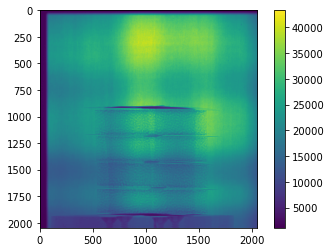

Loading Open Beam (OB)...
Loading Open Beam (OB)...Done!
(5, 2048, 2048)


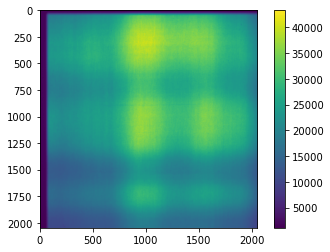

Loading Dark Current (DC)...
Loading Dark Current (DC)...Done!
(5, 2048, 2048)


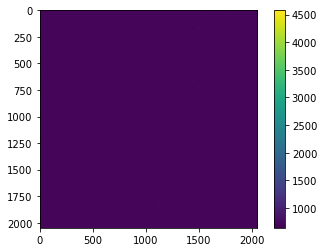

In [8]:
######### CT
proj_raw, theta, proj180_ind = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
print(proj_raw.shape)
plt.imshow(proj_raw[0])
plt.colorbar()
plt.show()
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
print(ob_raw.shape)
plt.imshow(ob_raw[0])
plt.colorbar()
plt.show()
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)
print(dc_raw.shape)
plt.imshow(dc_raw[0])
plt.colorbar()
plt.show()

# Define/crop ROI

Projection at 0 degree:


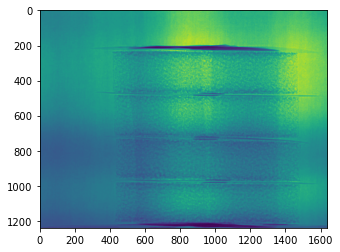

Projection at 180 degree:


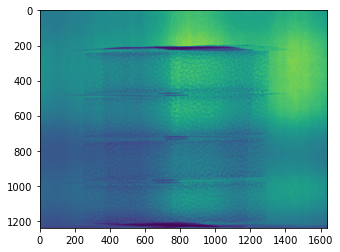

In [9]:
crop = True
if crop:
    slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob_raw[0], method='simple')
    roi_corners = rocku.set_roi(corners=slit_box_corners, xmin=100, ymin=700, xmax=1750, ymax=1950)
    proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj_raw, roi_corners)
    ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob_raw, roi_corners)
    dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc_raw, roi_corners)
else:
    proj_crop = proj_raw[:]
    ob_crop = ob_raw[:]
    dc_crop = dc_raw[:]
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.show()

# Remove Outliers

In [10]:
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff)

# Normalization

float32
(1162, 1239, 1639)


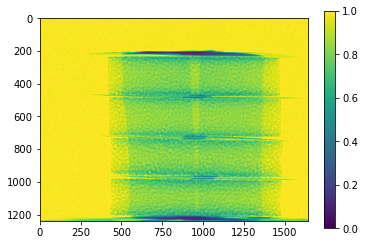

In [11]:
if ob_crop.shape[0] == 1:
    ob_med = ob_crop[:]
    print("Only 1 OB loaded.")
else:
    ob_med = np.median(ob_crop, axis=0).astype(np.ushort)
if dc_crop.shape[0] == 1:
    dc_med = dc_crop[:]
    print("Only 1 DC loaded.")
else:
    dc_med = np.median(dc_crop, axis=0).astype(np.ushort)
ob = ob_med - dc_med
proj = proj_crop - dc_med
proj_norm = np.true_divide(proj, ob)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Beam fluctuation correction (optional)

Beam fluctuation ROI at 0 degree:


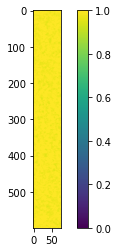

Beam fluctuation ROI at 180 degree:


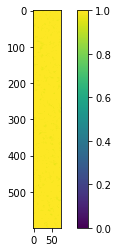

In [12]:
###################### need to change start
xmin = 5
xmax = 80
ymin = 500
ymax = 1100
###################### need to change start
bg_roi = [ymin, xmin, ymax, xmax] # 
bg_stack = proj_norm[:, bg_roi[0]:bg_roi[2], bg_roi[1]:bg_roi[3]]
print("Beam fluctuation ROI at 0 degree:")
plt.imshow(bg_stack[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Beam fluctuation ROI at 180 degree:")
plt.imshow(bg_stack[proj180_ind], vmin=0, vmax=1)
plt.colorbar()
plt.show()

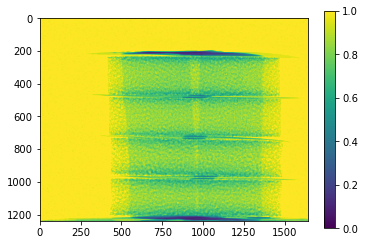

In [13]:
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi=bg_roi)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Ring Artifact Removal

In [14]:
# proj_rmv = rocku.remove_ring(proj_norm, algorithm="Vo")
############## bm3d, slightly better, but slow
proj_rmv = rocku.remove_ring(proj_norm, algorithm="bm3d")

Before ring removal:


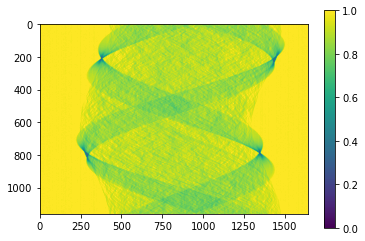

After ring removal:


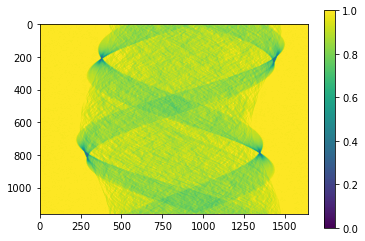

Difference:


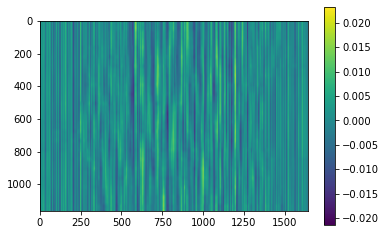

In [48]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_norm[:, slice_num, :], vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, slice_num, :], vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_rmv[:, slice_num, :]-proj_norm[:, slice_num, :])
plt.colorbar()
plt.show()

# Minus log conversion

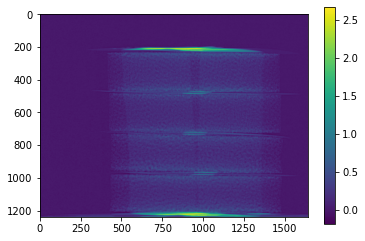

In [16]:
proj_mlog = tomopy.minus_log(proj_rmv)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Remove Outliers again (optional)

In [ ]:
proj_mlog = tomopy.remove_outlier(proj_mlog, gamma_diff)
proj_mlog = tomopy.remove_nan(proj_mlog)
# proj_mlog = tomopy.remove_neg(proj_mlog)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Find and correct tilt

Tilt correction ROI at 0 degree:


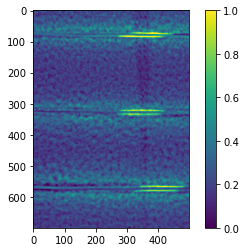

Tilt correction ROI at 180 degree:


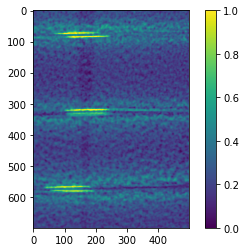

In [17]:
###################### need to change start
tt_xmin = 600
tt_xmax = 1100
tt_ymin = 400
tt_ymax = 1100
###################### need to change start
tt_roi = [tt_ymin, tt_xmin, tt_ymax, tt_xmax] # 
tt_0deg = proj_mlog[0, tt_roi[0]:tt_roi[2], tt_roi[1]:tt_roi[3]]
tt_180deg = proj_mlog[proj180_ind, tt_roi[0]:tt_roi[2], tt_roi[1]:tt_roi[3]]
print("Tilt correction ROI at 0 degree:")
plt.imshow(tt_0deg, vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree:")
plt.imshow(tt_180deg, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [18]:
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=tt_0deg, image180=tt_180deg)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle...
Found the tilt angle:  0.07641869873215597


In [19]:
proj_mlog_tilt = tilt.apply_tilt_correction(proj_mlog, tilt_ang.x)
# proj_mlog_tilt = tilt.apply_tilt_correction(proj_mlog, 0.112)

# proj_tilt = tilt.apply_tilt_correction(proj_rmv, 0.112)

/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/imars3d-0.1.3-py3.10.egg/imars3d/filters/tilt.py:115: TqdmWarning: Iterable length 1162 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
Applying tilt corr: 100%|███████████████████| 1162/1162 [00:19<00:00, 59.35it/s]


Projection at 0 degree:


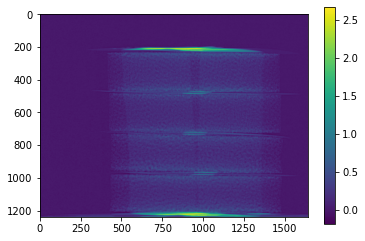

Projection at 180 degree (flipped):


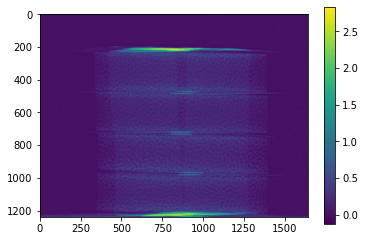

In [20]:
print("Projection at 0 degree:")
plt.imshow(proj_mlog[0])# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog[proj180_ind]))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Find Center of Rotation

In [21]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog[0,:,:]), np.squeeze(proj_mlog[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center) # 389.5

Estimated center of rotation: 929.5


In [22]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_rmv[0,:,:]), np.squeeze(proj_rmv[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center) # 389.5

Estimated center of rotation: 859.5


# Reconstruction

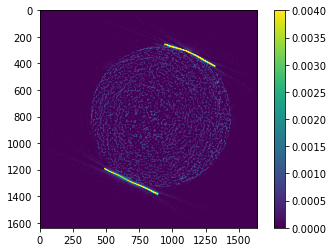

In [23]:
########## tomopy
recon = rocku.recon(proj_mlog_tilt, theta, rot_center=rot_center, algorithm='gridrec')
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
plt.imshow(recon[600, :, :], vmax=0.004, vmin=0)
plt.colorbar()
plt.show()

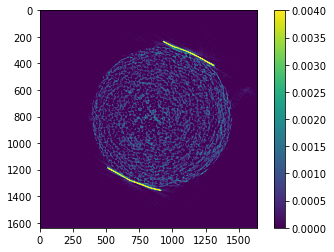

In [24]:
plt.imshow(recon[1000, :, :], vmax=0.004, vmin=0)
plt.colorbar()
plt.show()

In [25]:
pix_um = 42.7 #um
pix_cm = pix_um/10000
recon_cm = recon/pix_cm

# Export recon files

In [26]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_vo"
dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)

# Export proj files (optional)

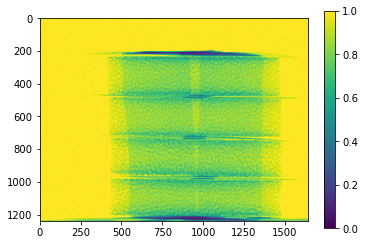

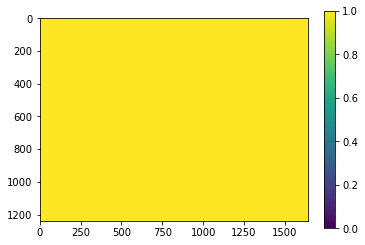

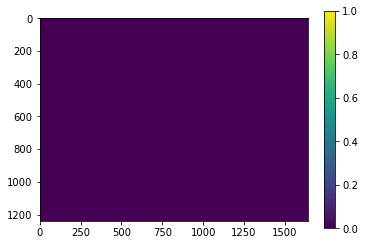

In [29]:
if proj_rmv.dtype == np.float32:
    proj_output = proj_rmv[:]
else:  
    proj_output = proj_rmv.astype(np.float32)
# proj_output = proj_norm.astype(np.float32)
# proj_output = np.exp(-1 * proj_output) # convert back to transmission
ob_output = np.ones((proj_output.shape[1],proj_output.shape[2]), dtype=proj_output.dtype)
dc_output = np.zeros((proj_output.shape[1],proj_output.shape[2]), dtype=proj_output.dtype)
plt.imshow(proj_output[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(ob_output, vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(dc_output, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [59]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon/" + sample_name + "_norm"
dxchange.write_tiff_stack(proj_output, fname=save_to + "/raw", overwrite=True, digit=4)
dxchange.write_tiff(ob_output, fname=save_to + '/ob_0000', overwrite=True)
dxchange.write_tiff(dc_output, fname=save_to + '/dc_0000', overwrite=True)